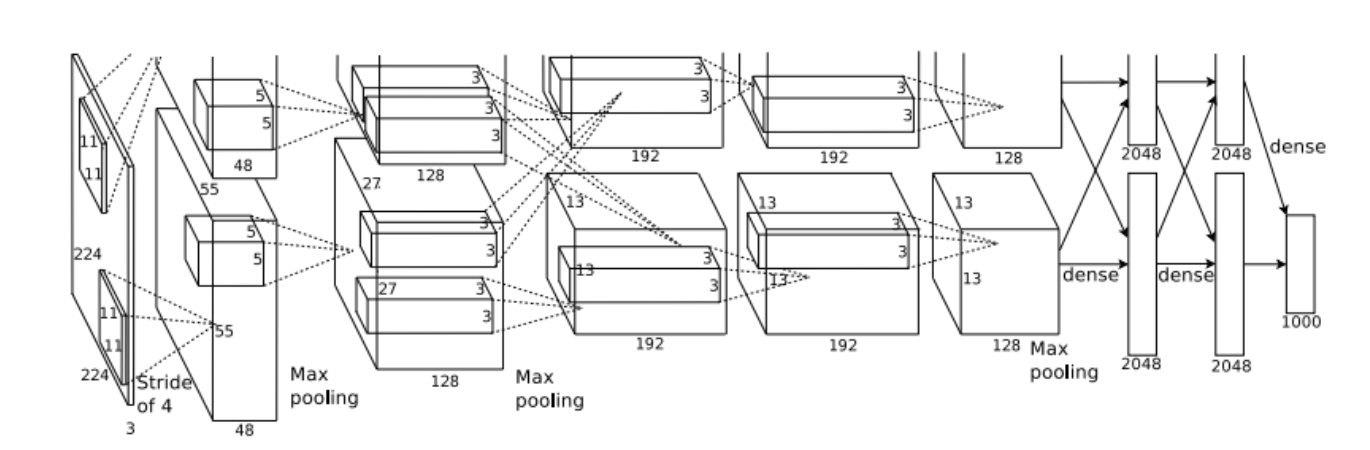
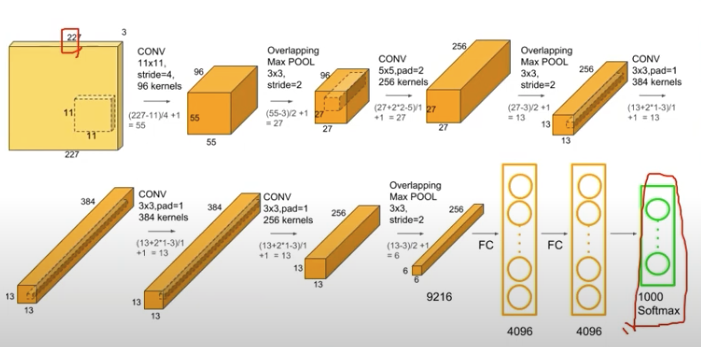

https://github.com/Devlee247/PyTorch-Implementations/blob/master/CNN/AlexNet.ipynb

# Lib Import

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from torchsummary import summary

In [17]:
# !pip3 install torchvision
# !pip3 install torchsummary

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.0 MB/s eta 0:00:00:00:010:01


# Model Implementation

In [24]:
class myAlexNet(nn.Module):
    """ Alex Net """
    
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels,96,kernel_size=11,stride=4),
            nn.ReLU(inplace= True),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size = 3, stride = 2) ## overlapping pooling
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(96,256,kernel_size = 5, stride=1, padding = 2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(2),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(256,384,kernel_size=3,stride=1, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(384,384,kernel_size=3,stride=1, padding = 1),
            nn.ReLU(inplace = True)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(384,256,kernel_size=3,stride=1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )
        self.avgpool = torch.nn.AdaptiveAvgPool2d((6,6)) #이건 뭐지
        self.classifier = nn.Sequential(
            nn.Linear(6*6*256, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,num_classes)
        )
    def forward(self,x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        # x = x.view(-1, 256*6*6)   # keras의 reshape (텐서 크기 2d 변경)
        return self.classifier(x)

## model summary

In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
model = myAlexNet(3,10).to(device)
summary(model, input_size=(3,227,227),device ='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

# Load Data

In [29]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(227),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:41<00:00, 4133014.53it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


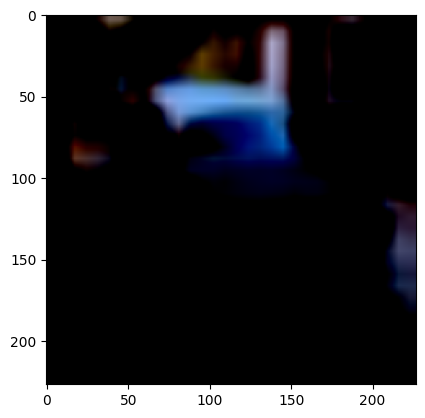

car


In [34]:
def custom_imshow(img):
    """ img show """
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
sample_num = 690

custom_imshow(trainset[sample_num][0])
print(classes[trainset[sample_num][1]])

# Model Train

In [36]:
# learning rate
lr = 1e-4 
# epoch..
epochs = 50 
# 오차 함수
criterion = nn.CrossEntropyLoss() # 교차 엔트로피: 분류 문제에서 주로 사용/ MSE는 회귀 문제에서 널리 사용한다.
# 최적화 알고리즘
optimizer = optim.Adam(model.parameters(), lr = lr) # 파라미터(편향, 가중치) 수정

In [41]:
for epoch in range(epochs):
    print("\nEpoch ", epoch)
    # train
    print("\nTrain:")
    model.train()
    train_loss = 0
    for i, (images, targets) in enumerate(train_loader): 
        images, targets = images.to(device), targets.to(device)
        
        pred = model(images) # 예측값 구하기
        loss = F.cross_entropy(pred, targets) # 비용 함수 구하기
        
        train_loss += loss.item() #현재 오차 더하기
        #
        optimizer.zero_grad() # 기울기 초기화
        loss.backward() # 미분 후 기울기 계산 여기서는 교차 엔트로피 계산
        optimizer.step() # 학습률을 곱하여 빼줌. -> 업데이트

        if ((i+1) % (len(train_loader) // 30) == 1) or i+1 == len(train_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(train_loader), train_loss/(i+1)))
    # val
    # 여기선 그냥 테스트 만
    print("\nValidation")
    model.eval()
    val_loss = 0
    for i, (images, targets) in enumerate(test_loader):
        images, targets = images.to(device), targets.to(device)
        preds = model(images)
        loss = criterion(preds, targets)   
        val_loss += loss.item()

        if ((i+1) % (len(test_loader) // 3) == 1) or i+1 == len(test_loader):
            print('[%3d/%3d] | Loss: %.5f'%(i+1, len(test_loader), val_loss/(i+1)))


Epoch  0

Train:


/Users/goodyoung/Desktop/GIt/myMLstudy/.mlvenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/goodyoung/Desktop/GIt/myMLstudy/.mlvenv/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) wil

[  1/12500] | Loss: 2.30194


KeyboardInterrupt: 

# 다시 구현

In [45]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels=96, kernel_size=11,stride=4),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels = 96, out_channels = 256, kernel_size = 5, stride=  1, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )        
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels = 384, kernel_size=3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=384, out_channels = 384, kernel_size=3, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(in_channels=384, out_channels = 256, kernel_size=3, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(256*6*6,4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096,4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096,1000),
        )

    def forward(self, x):
        x = self.layer1(x)       
        x = self.layer2(x)
        x = self.layer3(x)
        
        x = x.view(-1, 256 * 6* 6)
        x = self.fc(x)
        return x

In [41]:
model = myAlexNet(3,10).to(device)
summary(model, input_size=(3,227,227),device ='cuda')

NameError: name 'myAlexNet' is not defined

In [46]:
from torchsummary import summary

In [47]:
model = AlexNet()

In [48]:
summary(model,input_size = (3,227,227))

torch.Size([2, 3, 227, 227])
torch.Size([2, 96, 27, 27])
torch.Size([2, 256, 13, 13])
torch.Size([2, 256, 6, 6])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
         MaxPool2d-3           [-1, 96, 27, 27]               0
            Conv2d-4          [-1, 256, 27, 27]         614,656
              ReLU-5          [-1, 256, 27, 27]               0
         MaxPool2d-6          [-1, 256, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         885,120
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]       1,327,488
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         884,992
             ReLU-12          [-1, 256, 13, 13]       